<a href="https://colab.research.google.com/github/HDWilliams/CIFAR10-Classifier/blob/master/Cifar10_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import relevant libraries
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np


In [20]:
#import Cifar10 dataset
#set up transforms and dataloaders

#transforms
#norm_1 and norm_2 are of form (num1, num2, num3)
def load_data(img_size, norm_1, norm_2, batch_size):
  transform = transforms.Compose([transforms.Resize(img_size),
                                  transforms.RandomRotation(20),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(norm_1, norm_2)])
  #import dataset and create dataloaders
  trainset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
  testset = datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)

  #create validation set
  percent_validation = .2
  train_length = len(trainset)
  indicies = list(range(train_length))
  split = int(np.floor(train_length*percent_validation))
  np.random.shuffle(indicies)
  train_idx, val_idx = indicies[split:], indicies[:split]
  train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

  #create dataloaders
  trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(dataset=trainset,  batch_size=batch_size, sampler=val_sampler)
  testloader = torch.utils.data.DataLoader(dataset=testset,  batch_size=batch_size, shuffle=True)
  return trainloader, val_loader, testloader


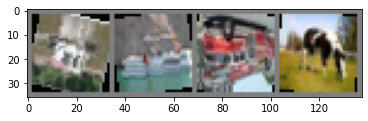

['ship', 'ship', 'truck', 'horse']


In [22]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
image, label = next(dataiter)

def image_grid(image, classes):
  # show images
  imshow(torchvision.utils.make_grid(image))
  # print label
  class_names = []
  for item in label:
    class_names.append(classes[item.numpy()])
  print(class_names)

image_grid(image, classes)


In [5]:
#set up CNN
import torch.nn as nn 
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    #define layers 2 Conv layers, 2 max pool, 3 fc layers
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.max_pool = nn.MaxPool2d(2, 2)
    #final image is 8 by 8. 32 by 32 image max pooled by 1/2, twice
    self.fc1 = nn.Linear(8*8*32, 120)
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, 10)

    self.drop = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.max_pool(self.conv1(x))
    x = self.max_pool(self.conv2(x))
    #flatten
    x = x.view(-1, 8*8*32)
    x = F.relu(self.drop(self.fc1(x)))
    x = F.relu(self.drop(self.fc2(x)))
    x = self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


In [6]:
#choose optimizer and loss function
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr = 0.003, momentum=0.5)

criterion = nn.CrossEntropyLoss()

#set up GPU training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [44]:
#create training and validation loops
def train_model(net, lr, trainloader, val_loader, epochs):

  #set optimizer and loss function
  optimizer = optim.SGD(net.parameters(), lr = lr, momentum=0.5)
  criterion = nn.CrossEntropyLoss()
  #set up GPU training
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  #send CNN to GPU
  net.to(device)
  running_loss = []
  val_running_loss = []
  prev_accuracy = 0
  for current_epoch in range(epochs):
    train_loss = 0
    for image, label in trainloader:
      #send images and labels to GPU
      image, label = image.to(device), label.to(device)
      optimizer.zero_grad()
      output = net(image)
      #calculate loss and gradients, and add to running loss
      loss = criterion(output, label)
      train_loss += loss.item()/len(trainloader)
      loss.backward()
      #step model based on calculated gradients
      optimizer.step()
    running_loss.append(train_loss)
    print(f"Training Loss: {train_loss}")
    
    val_loss = 0
    correct = 0
    total=0
    #validation loop
    #set model to no grad and eval mode
    with torch.no_grad():
      net.eval()
      for image, label in val_loader:
        #send image, label to GPU
        image, label = image.to(device), label.to(device)

        output = net(image)

        #calculate accuracy
        #get predicted indexes, find total number in a batch, calculate total number of correct and store as a python #
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        #calculate loss and add to running validation loss
        loss = criterion(output, label)
        val_loss += loss.item()/len(val_loader)

      val_running_loss.append(val_loss)

      #save model state dict checkpoint if validation accuracy has improved
      accuracy = 100*correct/total
      if accuracy > prev_accuracy:
        print('saving model checkpoint...')
        PATH = 'model_epoch' + str(current_epoch) + '.pth'
        torch.save(net.state_dict(), PATH)
        prev_accuracy = accuracy

      print(f"Validation Loss: {val_loss}" )
      print('Accuracy: %d %%' % accuracy)

      #switch model back to train mode
      net.train()

  return running_loss, val_running_loss
  #send trained model back to cpu for final testing and prediction
  net.to('cpu')

In [ ]:
#train
train_model(net, 0.003, trainloader, val_loader, 20)

In [33]:
#test loop
def run_test_loop(net, testloader):
  with torch.no_grad():
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    avg_loss = 0
    for images, labels in testloader:
      images , labels = images.to(device), labels.to(device)
      output = net(images)
      loss = criterion(output, labels)
      avg_loss += loss
      _, prediction = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (prediction == labels).sum().item()
    print(f"Accuracy: {100*correct/total}")
    print(f"Avg Loss: {avg_loss/len(testloader)}")
  net.train()


In [ ]:
#prediction
def predict():
  net.eval()
  net.to('cpu')
  dataiter = iter(testloader)
  images, labels = dataiter.next()
  output = net(images)
  _, prediction = torch.max(output.data, 1)
  imshow(torchvision.utils.make_grid(images))
  class_labels = []
  true_labels = []
  for j in range(len(prediction)):
    class_labels.append(classes[prediction[j]])
    true_labels.append(classes[labels[j]])
  print(f'Predicted: {class_labels}')
  print(f'Ground Truth: {true_labels}')

predict()

# Transfer Learning

In [ ]:
#Load resnet18 pretrained
import torchvision.models as models
resnet_model = models.resnet18(pretrained=True)

#set grad to false for classifier
for param in resnet_model.parameters():
  param.requires_grad = False

#replace fc layer with layer of output 10 classes
resnet_model.fc = nn.Linear(512, 10)
for param in resnet_model.fc.parameters():
  param.requires_grad = True

print(resnet_model)

In [ ]:
#load data in resnet18 format
train_ldr, val_ldr, test_ldr = load_data(224, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225), 1)


In [ ]:
#visualize data
dataiter = iter(train_ldr)
image, label = dataiter.next()
image_grid(image, classes)

In [48]:
train_model(resnet_model, 0.008, train_ldr, val_ldr, 20)

Training Loss: 4.234532606769708
saving model checkpoint...
Validation Loss: 17.78632719638902
Accuracy: 40 %
Training Loss: 4.18087179985827
saving model checkpoint...
Validation Loss: 22.351942745347568
Accuracy: 36 %
Training Loss: 4.142514884201417
saving model checkpoint...
Validation Loss: 21.8354249982251
Accuracy: 38 %
Training Loss: 4.143294329198528
saving model checkpoint...
Validation Loss: 22.429122278314097
Accuracy: 36 %
Training Loss: 4.127117457074429
saving model checkpoint...
Validation Loss: 20.293280946086423
Accuracy: 41 %
Training Loss: 4.1267288672231714
saving model checkpoint...
Validation Loss: 28.69057978662406
Accuracy: 34 %
Training Loss: 4.121588684362689
saving model checkpoint...
Validation Loss: 25.13124783492116
Accuracy: 38 %
Training Loss: 4.128384230608793
saving model checkpoint...
Validation Loss: 29.75952960096622
Accuracy: 34 %
Training Loss: 4.111815922581578
saving model checkpoint...
Validation Loss: 29.888630038799946
Accuracy: 33 %
Trainin

KeyboardInterrupt: ignored